In [1]:
#!pip install tensorflow==2.7.0

In [2]:
#pip install opencv-python-headless

In [3]:
from distutils import extension
from logging import exception
import os
from datetime import datetime as dt
from regex import E
from sqlalchemy import intersect
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np 
import pathlib
from keras.callbacks import ModelCheckpoint   
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!ls "/content/gdrive/MyDrive/cbisddsm"

Test_output_full  Test_output_mask  Train_output_full  Train_output_mask


In [6]:
# data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Images/Train")
# data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Images/Test')

In [7]:
seed = 43
encoder_input_width = 512
encode_input_channels = 3
encoder_input_shape = (encoder_input_width, encoder_input_width, encode_input_channels)

kernsize = 3
decoder_kernel_size = (kernsize, kernsize)
stride = 2
decoder_strides = (stride, stride)
decoder_padding = "same"
decoder_activation = None
final_layer_filters = 1
final_layer_activation = "sigmoid"

train_full_img_dir = "/content/gdrive/MyDrive/cbisddsm/Train_output_full"
train_mask_img_dir = "/content/gdrive/MyDrive/cbisddsm/Train_output_mask"

test_full_img_dir = "/content/gdrive/MyDrive/cbisddsm/Test_output_full"
test_mask_img_dir = "/content/gdrive/MyDrive/cbisddsm/Test_output_mask"
results_dir = "/content/results/fit"
extension = ".png"

target_size = (512, 512)

brightness_delta = 0.3
batch_size = 10

weight_decay = 1e-5

validate = False
loss = "binary_crossentropy"
learning_rate = 0.0001
dropout = 0.5
dropout_training = True
num_epochs = 40
callback_monitor = "iouMetric"
callback_mode = "max"
ckpt_save_weights_only = True
ckpt_save_best_only = True
earlystop_patience = 20
restore_best_weights = True

In [8]:
# x_paths_list = []
# for full in os.listdir(train_full_img_dir):
#   if full.endswith(extension):
#     x_paths_list.append(os.path.join(train_full_img_dir, full))

# print(len(x_paths_list))

In [9]:
def datasetPaths(full_img_dir, mask_img_dir):
        try:
            x_paths_list = []
            y_paths_list = []

            for full in os.listdir(full_img_dir):
                if full.endswith(extension):
                    x_paths_list.append(os.path.join(full_img_dir, full))
            
            for full in os.listdir(mask_img_dir):
                if full.endswith(extension):
                    y_paths_list.append(os.path.join(mask_img_dir, full))
            
            x_paths_list.sort()
            y_paths_list.sort()

            return x_paths_list, y_paths_list
        except Exception as e:
            print(f"Error in datasetPaths {e}")

In [10]:
# def loadFullImg(path, dsize):
#         try:
#             if not isinstance(path, str):
#                 path = path.decode()
             
            
#             s3_client = boto3.resource('s3')
#             obj = s3_client.get_object(Bucket='cbisddsm', Key=path)
#             nparr = np.frombuffer(obj['Body'].read(), np.uint8)
#             img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
#             print(f'type type{img}')
#             #bucket = s3_resource.Bucket('cbisddsm')
#             #print(f'bucket.Object(path) {bucket.Object(path)}')
#             #img = bucket.Object(path).get().get('Body').read()
#             #print(f'img {img}')
#             #img = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_COLOR)
           
            
#             #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#             img = cv2.resize(src=img, dsize=dsize)

#             norm_img = (img - img.min()) / (img.max() - img.min())

#             full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
#             print(f'done for path {path}')
#             return full_img
        
#         except Exception as e:
#             print(f"There is an error in loadFullImg {e}")
            

    
 

In [11]:
def loadFullImg(path, dsize):
        try:
            if not isinstance(path, str):
                path = path.decode()
            
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            #print(type(img))
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())
            #print(f'After norm_img')
            #print(f'type {norm_img.shape}')
            full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
            #print(f'After full_img')
            #print(f'type {full_img.shape}')
            #print(f'done for path {path} with shape {full_img.shape}')
            return full_img
        
        except Exception as e:
            print(f"There is an error in loadFullImg {e}")

In [12]:
# s3 = boto3.resource('s3')
# my_bucket = s3.Bucket('cbisddsm')
# i = 0
# for object_summary in my_bucket.objects.filter(Prefix='Train_output_full'):    
#     if i == 0:
#         pass
#     else:
#         print(object_summary.key)
#         img = loadFullImg(object_summary.key, target_size)
#         print(img.shape)
#         #break
#     i += 1
    
    
#             #print(object_summary.key)
        
#             #x_paths_list.append(object_summary.key)


In [13]:
def loadMaskImg(path, dsize):
        try:
            if not isinstance(path, str):
                path=path.decode()
            
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())

            mask_img = np.expand_dims(norm_img, axis=-1)
            #print(f'done for path {path} with shape {mask_img.shape}')
            return mask_img

        except Exception as e:
            print(f"Error in loadMaskIMG {e}")

In [14]:
# def loadMaskImg(path, dsize):
#         try:
#             if not isinstance(path, str):
#                 path=path.decode()
             
#             s3_resource = boto3.resource('s3')
#             bucket = s3_resource.Bucket('cbisddsm')
# #             bucket = s3_resource.Bucket('cbisddsm')
#             img = bucket.Object(path).get().get('Body').read()
#             img = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_COLOR)
#             print(f'type type(img)')
#             #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#             img = cv2.resize(src=img, dsize=dsize)

#             norm_img = (img - img.min()) / (img.max() - img.min())

#             mask_img = np.expand_dims(norm_img, axis=-1)

#             return mask_img

#         except Exception as e:
#             print("Error in loadMaskIMG")

In [15]:
def tfParse(x_path, y_path):
        try:
            def _parse(x_path, y_path):
                x = loadFullImg(path=x_path, dsize=target_size)
                y = loadMaskImg(path=y_path, dsize=target_size)
                return x,y

            x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float64, tf.float64])

            x.set_shape([target_size[0], target_size[0], 3])
            y.set_shape([target_size[0], target_size[1], 1])

            return x,y
            

        except Exception as e:
            print(f"Error in tfParse {e}")

In [16]:
def imgAugment(x_img, y_img):
        try:
            if tf.random.uniform(()) > 0.5:
                x_img = tf.image.flip_up_down(image=x_img)
                y_img = tf.image.flip_up_down(image=y_img)

            x_img = tf.image.random_brightness(
                image=x_img, max_delta=brightness_delta
            )

            return x_img, y_img

        except:
            print("Erro in imgAugument")

In [17]:
 def makeTFDataset( shuffle, augument, x_paths_list, y_paths_list, batch_size):
        try:
            ds = tf.data.Dataset.from_tensor_slices((x_paths_list, y_paths_list))
            
            if shuffle:
                ds = ds.shuffle(buffer_size=len(x_paths_list))

            ds = ds.map(tfParse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            if augument:
                ds = ds.map(imgAugment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

            ds = ds.batch(batch_size=batch_size, drop_remainder=False)
            ds = ds.repeat()

            return ds

        except Exception as e:
            print(f"Error in make TFDataset {e}")

In [18]:
def buildEncoder():
        try:
            VGG16_ = keras.applications.VGG16(
                include_top=False, weights="imagenet", input_shape=encoder_input_shape,
            )

            layer_names = [layer.name for layer in VGG16_.layers]

            all_layer_outputs = [
               VGG16_.get_layer(layer).output for layer in layer_names
            ]

            encoder_model = keras.Model(inputs=VGG16_.input, outputs=all_layer_outputs)

            encoder_model.trainable = False

            return encoder_model 
        
        except Exception as e:
            print("Error in buildEncoder")

In [19]:
# def buildUnet():
#         try:
#             unet_input = keras.Input(
#                 shape= encoder_input_shape, name="unet_input_layer"
#             )

#             x = unet_input
#             encoder_model = buildEncoder()
#             all_encoder_layer_outputs = encoder_model(x)

#             encoded_img = all_encoder_layer_outputs[-1]

#             skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 5,9, 13, 17]]
#             #skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 4, 6, 12, 15]]
            
#             decoder_filters = int(encoded_img.shape[-1])

#             # ------------------------------------------
#             # Block 5: 7x7 -> 14x14
#             #  - `encoded_img` as initial input for decoder
#             x = keras.layers.Conv2DTranspose(
#                 name="block5_up_convT",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=decoder_strides,
#                 padding=decoder_padding,
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=decoder_activation,
#             )(encoded_img)

#             x = keras.layers.Concatenate(name="block5_up_concat", axis=-1)(
#                 [x, skip_outputs[4]]
#             )

#             x = keras.layers.Dropout(
#                 name="block5_up_dropout", rate=dropout, seed=seed
#             )(x, training=dropout_training)

#             x = keras.layers.Conv2D(
#                 name="block5_up_conv3",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block5_up_conv2",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block5_up_conv1",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 kernel_regularizer=l2(weight_decay), 
#                 padding="same",
#                 activation="relu",
#             )(x)

#             # ------------------------------------------
#             # Block 4: 14x14 -> 28x28
#             x = keras.layers.Conv2DTranspose(
#                 name="block4_up_convT",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=decoder_strides,
#                 padding=decoder_padding,
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=decoder_activation,
#             )(x)

#             x = keras.layers.Concatenate(name="block4_up_concat", axis=-1)(
#                 [x, skip_outputs[3]]
#             )

#             x = keras.layers.Dropout(
#                 name="block4_up_dropout", rate=dropout, seed=seed
#             )(x, training=dropout_training)

#             x = keras.layers.Conv2D(
#                 name="block4_up_conv3",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block4_up_conv2",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block4_up_conv1",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)

#             # ------------------------------------------
#             # Block 3: 28x28 -> 56x56
#             x = keras.layers.Conv2DTranspose(
#                 name="block3_up_convT",
#                 filters=int(decoder_filters / 2),
#                 kernel_size=decoder_kernel_size,
#                 strides=decoder_strides,
#                 padding=decoder_padding,
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=decoder_activation,
#             )(x)

#             x = keras.layers.Concatenate(name="block3_up_concat", axis=-1)(
#                 [x, skip_outputs[2]]
#             )

#             x = keras.layers.Dropout(
#                 name="block3_up_dropout", rate=dropout, seed=seed
#             )(x, training=dropout_training)

#             x = keras.layers.Conv2D(
#                 name="block3_up_conv3",
#                 filters=int(decoder_filters / 2),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block3_up_conv2",
#                 filters=int(decoder_filters / 2),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 kernel_regularizer=l2(weight_decay), 
#                 padding="same",
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block3_up_conv1",
#                 filters=int(decoder_filters / 2),
#                 kernel_size=decoder_kernel_size,
#                 kernel_regularizer=l2(weight_decay), 
#                 strides=(1, 1),
#                 padding="same",
#                 activation="relu",
#             )(x)

#             # ------------------------------------------
#             # Block 2: 56x56 -> 112x112
#             x = keras.layers.Conv2DTranspose(
#                 name="block2_up_convT",
#                 filters=int(decoder_filters / 4),
#                 kernel_size=decoder_kernel_size,
#                 strides=decoder_strides,
#                 padding=decoder_padding,
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=decoder_activation,
#             )(x)

#             x = keras.layers.Concatenate(name="block2_up_concat", axis=-1)(
#                 [x, skip_outputs[1]]
#             )

#             x = keras.layers.Dropout(
#                 name="block2_up_dropout", rate=dropout, seed=seed
#             )(x, training=dropout_training)

#             x = keras.layers.Conv2D(
#                 name="block2_up_conv2",
#                 filters=int(decoder_filters / 4),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 kernel_regularizer=l2(weight_decay), 
#                 padding="same",
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block2_up_conv1",
#                 filters=int(decoder_filters / 4),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 kernel_regularizer=l2(weight_decay), 
#                 padding="same",
#                 activation="relu",
#             )(x)

#             # ------------------------------------------
#             # Block 1: 112x112 -> 224x224
#             x = keras.layers.Conv2DTranspose(
#                 name="block1_up_convT",
#                 filters=int(decoder_filters / 8),
#                 kernel_size=decoder_kernel_size,
#                 strides=decoder_strides,
#                 padding=decoder_padding,
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=decoder_activation,
#             )(x)

#             x = keras.layers.Concatenate(name="block1_up_concat", axis=-1)(
#                 [x, skip_outputs[0]]
#             )

#             x = keras.layers.Dropout(
#                 name="block1_up_dropout", rate=dropout, seed=seed
#             )(x, training=dropout_training)

#             x = keras.layers.Conv2D(
#                 name="block1_up_conv2",
#                 filters=int(decoder_filters / 8),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             decoded_img = keras.layers.Conv2D(
#                 name="block1_up_conv1",
#                 filters=int(decoder_filters / 8),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)

#             # ------------------------------------------
#             # Final conv layer
#             final_img = keras.layers.Conv2D(
#                 name="final_up_conv",
#                 filters=final_layer_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=final_layer_activation,
#             )(decoded_img)

#             # ======
#             #  Unet
#             # ======

#             unet = keras.Model(inputs=unet_input, outputs=final_img, name="Unet_VGG16")

#             return unet
#         except Exception as e:
#             print(f"Error in Build Unet {e}")

In [20]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same",kernel_regularizer=l2(0.1))(x)
    #x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = Dropout(rate=dropout, seed=seed
            )(x, training=dropout_training)

    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

In [21]:
def iouMetric( y_true, y_pred):
        try:
            def compute_iou(y_true, y_pred):
                intersection = (y_true * y_pred).sum()
                union = y_true.sum() + y_pred.sum() - intersection
                x = (intersection + 1e-15) / (union + 1e-15)
                x = x.astype(np.float32)
                return x
            
            return tf.numpy_function(compute_iou, [y_true, y_pred], tf.float32)
            
        except Exception as e:
            print(f"Error in iouMetric {E}")

In [22]:
def dice_coef(y_true, y_pred):
        try:
            # def dice(true, pred, k = 1):
            #     intersection = np.sum(pred[true==k]) * 2.0
            #     dice = intersection / (np.sum(pred) + np.sum(true))
            #     return dice 
            # return tf.numpy_function(dice, [y_true, y_pred], tf.double)
            
            y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
            y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
            intersection = tf.reduce_sum(y_true_f * y_pred_f)
            return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)
        except Exception as e:
            print(f"Error in dice_coef {e}")

In [23]:
def compile_( model):
        try:
            loss = keras.losses.BinaryCrossentropy(from_logits=False)
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
            metrics = ["accuracy", iouMetric, dice_coef]
            model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

            return model
        except Exception as e:
            print(f"Failed at compile_ {e}")

In [24]:
 test_x, test_y = datasetPaths(
            full_img_dir=test_full_img_dir,
            mask_img_dir=test_mask_img_dir
        )
        

In [25]:
# def evaluate(path,target_size):
#   full_img_lst = []
#   print(len(path))
#   for imgpath in path:
#     full_img = loadFullImg(imgpath, target_size)
#     full_img_lst.append(full_img)
#     #img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
#     #print(full_img.shape)
#   return full_img_lst
  
# full_img_lst = evaluate(test_x, target_size)

In [26]:
# def evaluate_mask(path,target_size):
#   mask_img_lst = []
#   print(len(path))
#   for imgpath in path:
#     mask_img = loadMaskImg(imgpath, target_size)
#     mask_img_lst.append(mask_img)
#     #img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
#     #print(full_img.shape)
#   return mask_img_lst
  
# mask_img_lst = evaluate(test_y, target_size)

In [27]:
# img = cv2.imread(test_x[0], cv2.IMREAD_GRAYSCALE)
# print(img)

In [28]:
# actual_x, actual_y =tfParse(test_x, test_y)

In [29]:
# full_img_lst[0]

In [30]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)  
model_time = dt.now().strftime("%Y%m%d_%H%M%S")
model_folder = os.path.join(results_dir, model_time)
os.makedirs(model_folder)

tensorboard_folder = os.path.join(model_folder, "tensorlogs")
os.makedirs(tensorboard_folder)

ckpt_folder = os.path.join(model_folder, "checkpoints")
os.makedirs(ckpt_folder)

csv_logger_folder = os.path.join(model_folder, "csv_logger")
os.makedirs(csv_logger_folder)

hist_folder = os.path.join(model_folder, "model_history")
os.makedirs(hist_folder)

saved_model_folder = os.path.join(model_folder, "Saved_model")
os.makedirs(saved_model_folder)

model_params_folder = os.path.join(model_folder, "model_params")
os.makedirs(model_params_folder)

train_x, train_y = datasetPaths(
    full_img_dir=train_full_img_dir,
    mask_img_dir=train_mask_img_dir 
)

test_x, test_y = datasetPaths(
    full_img_dir=test_full_img_dir,
    mask_img_dir=test_mask_img_dir
)

train_ds = makeTFDataset(shuffle=True, augument=True,
x_paths_list = train_x, y_paths_list=train_y, batch_size=batch_size)


test_ds = makeTFDataset(
    shuffle=False,
    augument=False,
    x_paths_list=test_x,
    y_paths_list=test_y,
    batch_size=batch_size)      
    
#unet = buildUnet()
input_shape = (512, 512, 3)
model = build_resnet50_unet(input_shape)
model.summary()

unet = compile_(model=model)

# ckpt_path = (ckpt_folder + f"/{model_time}" + "_Epoch-{epoch:03d}" + "_IOU-{iouMetric:.8f")
ckpt_path = (ckpt_folder + f"/{model_time}")

ckpt_callback = keras.callbacks.ModelCheckpoint(
    filepath= ckpt_path,
    monitors= callback_monitor,
    mode= callback_mode,
    save_weights_only= ckpt_save_weights_only,
    save_best_only=ckpt_save_best_only,
    verbose=1
)

es_callback = keras.callbacks.EarlyStopping(
    patience= earlystop_patience,
    monitor= callback_monitor,
    mode= callback_mode,
    restore_best_weights= restore_best_weights,
)

# TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir=tensorboard_folder, histogram_freq=1, profile_batch=0
)

# CSV Logger
csv_logger_path = os.path.join(csv_logger_folder, "csv_logger.csv")
csv_logger = keras.callbacks.CSVLogger(
    filename=csv_logger_path, separator=",", append=True
)

# Putting them together
callbacks = [ckpt_callback, es_callback, tb_callback, csv_logger, checkpointer]

train_steps = len(train_x) // batch_size
test_steps = len(test_x) // batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(test_x) % batch_size != 0:
    test_steps += 1

print()
print(f"Size of training set = {len(train_x)}")
print(f"Size of test set = {len(test_x)}")
print(f"Number of epochs = {num_epochs}")
print(f"Batch size = {batch_size}")
print(f"Number of training steps per epoch = {train_steps}")
print(f"Number of test steps per epoch = {test_steps}")
print()

# if __name__ == "__main__":     
    
#     model.summary()


if validate:
        history = unet.fit(
            train_ds,
            validation_data=test_ds,
            epochs=num_epochs,
            steps_per_epoch=train_steps,
            validation_steps=test_steps,
            callbacks=callbacks,
            verbose=1,
        )
elif not validate:
    history = unet.fit(
        train_ds,
        epochs=num_epochs,
        steps_per_epoch=train_steps,
        callbacks=callbacks,
        verbose=1
    )

#y_hat = unet.evaluate(test_ds)

print("Completed")     
        

94781440/94765736 [==============================] - 0s 0us/step
Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                    

124/124 [==============================] - 425s 3s/step - loss: 56.2382 - accuracy: 0.9867 - iouMetric: 0.0075 - dice_coef: 0.0149
Epoch 2/40
124/124 [==============================] - ETA: 0s - loss: 16.8875 - accuracy: 0.9961 - iouMetric: 0.0199 - dice_coef: 0.0389

124/124 [==============================] - 221s 2s/step - loss: 16.8875 - accuracy: 0.9961 - iouMetric: 0.0199 - dice_coef: 0.0389
Epoch 3/40
124/124 [==============================] - ETA: 0s - loss: 5.5622 - accuracy: 0.9961 - iouMetric: 0.0288 - dice_coef: 0.0558

124/124 [==============================] - 222s 2s/step - loss: 5.5622 - accuracy: 0.9961 - iouMetric: 0.0288 - dice_coef: 0.0558
Epoch 4/40
124/124 [==============================] - ETA: 0s - loss: 2.1072 - accuracy: 0.9961 - iouMetric: 0.0364 - dice_coef: 0.0701

124/124 [==============================] - 224s 2s/step - loss: 2.1072 - accuracy: 0.9961 - iouMetric: 0.0364 - dice_coef: 0.0701
Epoch 5/40
124/124 [==============================] - ETA: 0s - loss: 0.8925 - accuracy: 0.9961 - iouMetric: 0.0447 - dice_coef: 0.0852

124/124 [==============================] - 223s 2s/step - loss: 0.8925 - accuracy: 0.9961 - iouMetric: 0.0447 - dice_coef: 0.0852
Epoch 6/40
124/124 [==============================] - ETA: 0s - loss: 0.4054 - accuracy: 0.9961 - iouMetric: 0.0550 - dice_coef: 0.1040

124/124 [==============================] - 226s 2s/step - loss: 0.4054 - accuracy: 0.9961 - iouMetric: 0.0550 - dice_coef: 0.1040
Epoch 7/40
124/124 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.9961 - iouMetric: 0.0648 - dice_coef: 0.1213

124/124 [==============================] - 224s 2s/step - loss: 0.1956 - accuracy: 0.9961 - iouMetric: 0.0648 - dice_coef: 0.1213
Epoch 8/40
124/124 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.9961 - iouMetric: 0.0788 - dice_coef: 0.1454

124/124 [==============================] - 226s 2s/step - loss: 0.1009 - accuracy: 0.9961 - iouMetric: 0.0788 - dice_coef: 0.1454
Epoch 9/40
124/124 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9961 - iouMetric: 0.0884 - dice_coef: 0.1619

124/124 [==============================] - 226s 2s/step - loss: 0.0584 - accuracy: 0.9961 - iouMetric: 0.0884 - dice_coef: 0.1619
Epoch 10/40
124/124 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9961 - iouMetric: 0.0863 - dice_coef: 0.1582

124/124 [==============================] - 223s 2s/step - loss: 0.0402 - accuracy: 0.9961 - iouMetric: 0.0863 - dice_coef: 0.1582
Epoch 11/40
124/124 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9961 - iouMetric: 0.1110 - dice_coef: 0.1992

124/124 [==============================] - 223s 2s/step - loss: 0.0287 - accuracy: 0.9961 - iouMetric: 0.1110 - dice_coef: 0.1992
Epoch 12/40
124/124 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9961 - iouMetric: 0.1218 - dice_coef: 0.2164

124/124 [==============================] - 227s 2s/step - loss: 0.0237 - accuracy: 0.9961 - iouMetric: 0.1218 - dice_coef: 0.2164
Epoch 13/40
124/124 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9961 - iouMetric: 0.1302 - dice_coef: 0.2294

124/124 [==============================] - 229s 2s/step - loss: 0.0209 - accuracy: 0.9961 - iouMetric: 0.1302 - dice_coef: 0.2294
Epoch 14/40
124/124 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9961 - iouMetric: 0.1328 - dice_coef: 0.2334

124/124 [==============================] - 230s 2s/step - loss: 0.0197 - accuracy: 0.9961 - iouMetric: 0.1328 - dice_coef: 0.2334
Epoch 15/40
124/124 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9961 - iouMetric: 0.1345 - dice_coef: 0.2359

124/124 [==============================] - 226s 2s/step - loss: 0.0189 - accuracy: 0.9961 - iouMetric: 0.1345 - dice_coef: 0.2359
Epoch 16/40
124/124 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9961 - iouMetric: 0.1395 - dice_coef: 0.2440

124/124 [==============================] - 230s 2s/step - loss: 0.0183 - accuracy: 0.9961 - iouMetric: 0.1395 - dice_coef: 0.2440
Epoch 17/40
124/124 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9961 - iouMetric: 0.1433 - dice_coef: 0.2498

124/124 [==============================] - 228s 2s/step - loss: 0.0175 - accuracy: 0.9961 - iouMetric: 0.1433 - dice_coef: 0.2498
Epoch 18/40
124/124 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9961 - iouMetric: 0.1406 - dice_coef: 0.2455

124/124 [==============================] - 231s 2s/step - loss: 0.0173 - accuracy: 0.9961 - iouMetric: 0.1406 - dice_coef: 0.2455
Epoch 19/40
124/124 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9961 - iouMetric: 0.1446 - dice_coef: 0.2520

124/124 [==============================] - 230s 2s/step - loss: 0.0166 - accuracy: 0.9961 - iouMetric: 0.1446 - dice_coef: 0.2520
Epoch 20/40
124/124 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9961 - iouMetric: 0.1445 - dice_coef: 0.2516

124/124 [==============================] - 228s 2s/step - loss: 0.0163 - accuracy: 0.9961 - iouMetric: 0.1445 - dice_coef: 0.2516
Epoch 21/40
124/124 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9961 - iouMetric: 0.1473 - dice_coef: 0.2559

124/124 [==============================] - 226s 2s/step - loss: 0.0158 - accuracy: 0.9961 - iouMetric: 0.1473 - dice_coef: 0.2559
Epoch 22/40
124/124 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9961 - iouMetric: 0.1473 - dice_coef: 0.2560

124/124 [==============================] - 230s 2s/step - loss: 0.0155 - accuracy: 0.9961 - iouMetric: 0.1473 - dice_coef: 0.2560
Epoch 23/40
124/124 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9961 - iouMetric: 0.1477 - dice_coef: 0.2565

124/124 [==============================] - 232s 2s/step - loss: 0.0151 - accuracy: 0.9961 - iouMetric: 0.1477 - dice_coef: 0.2565
Epoch 24/40
124/124 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9961 - iouMetric: 0.1494 - dice_coef: 0.2593

124/124 [==============================] - 230s 2s/step - loss: 0.0147 - accuracy: 0.9961 - iouMetric: 0.1494 - dice_coef: 0.2593
Epoch 25/40
124/124 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9961 - iouMetric: 0.1489 - dice_coef: 0.2586

124/124 [==============================] - 226s 2s/step - loss: 0.0145 - accuracy: 0.9961 - iouMetric: 0.1489 - dice_coef: 0.2586
Epoch 26/40
124/124 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9961 - iouMetric: 0.1448 - dice_coef: 0.2524

124/124 [==============================] - 226s 2s/step - loss: 0.0146 - accuracy: 0.9961 - iouMetric: 0.1448 - dice_coef: 0.2524
Epoch 27/40
124/124 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9961 - iouMetric: 0.1487 - dice_coef: 0.2580

124/124 [==============================] - 228s 2s/step - loss: 0.0140 - accuracy: 0.9961 - iouMetric: 0.1487 - dice_coef: 0.2580
Epoch 28/40
124/124 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9961 - iouMetric: 0.1474 - dice_coef: 0.2562

124/124 [==============================] - 227s 2s/step - loss: 0.0142 - accuracy: 0.9961 - iouMetric: 0.1474 - dice_coef: 0.2562
Epoch 29/40
124/124 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9961 - iouMetric: 0.1508 - dice_coef: 0.2615

124/124 [==============================] - 227s 2s/step - loss: 0.0135 - accuracy: 0.9961 - iouMetric: 0.1508 - dice_coef: 0.2615
Epoch 30/40
124/124 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9961 - iouMetric: 0.1534 - dice_coef: 0.2653

124/124 [==============================] - 230s 2s/step - loss: 0.0133 - accuracy: 0.9961 - iouMetric: 0.1534 - dice_coef: 0.2653
Epoch 31/40
124/124 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9961 - iouMetric: 0.1552 - dice_coef: 0.2681

124/124 [==============================] - 228s 2s/step - loss: 0.0131 - accuracy: 0.9961 - iouMetric: 0.1552 - dice_coef: 0.2681
Epoch 32/40
124/124 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9961 - iouMetric: 0.1557 - dice_coef: 0.2689

124/124 [==============================] - 231s 2s/step - loss: 0.0130 - accuracy: 0.9961 - iouMetric: 0.1557 - dice_coef: 0.2689
Epoch 33/40
124/124 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9961 - iouMetric: 0.1563 - dice_coef: 0.2696

124/124 [==============================] - 228s 2s/step - loss: 0.0129 - accuracy: 0.9961 - iouMetric: 0.1563 - dice_coef: 0.2696
Epoch 34/40
124/124 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9961 - iouMetric: 0.1640 - dice_coef: 0.2813

124/124 [==============================] - 230s 2s/step - loss: 0.0124 - accuracy: 0.9961 - iouMetric: 0.1640 - dice_coef: 0.2813
Epoch 35/40
124/124 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9961 - iouMetric: 0.1655 - dice_coef: 0.2833

124/124 [==============================] - 231s 2s/step - loss: 0.0123 - accuracy: 0.9961 - iouMetric: 0.1655 - dice_coef: 0.2833
Epoch 36/40
124/124 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9961 - iouMetric: 0.1712 - dice_coef: 0.2917

124/124 [==============================] - 228s 2s/step - loss: 0.0121 - accuracy: 0.9961 - iouMetric: 0.1712 - dice_coef: 0.2917
Epoch 37/40
124/124 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9961 - iouMetric: 0.1763 - dice_coef: 0.2991

124/124 [==============================] - 232s 2s/step - loss: 0.0118 - accuracy: 0.9961 - iouMetric: 0.1763 - dice_coef: 0.2991
Epoch 38/40
124/124 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9961 - iouMetric: 0.1830 - dice_coef: 0.3087

124/124 [==============================] - 228s 2s/step - loss: 0.0116 - accuracy: 0.9961 - iouMetric: 0.1830 - dice_coef: 0.3087
Epoch 39/40
124/124 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9961 - iouMetric: 0.1905 - dice_coef: 0.3195

124/124 [==============================] - 230s 2s/step - loss: 0.0114 - accuracy: 0.9961 - iouMetric: 0.1905 - dice_coef: 0.3195
Epoch 40/40
124/124 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9961 - iouMetric: 0.1967 - dice_coef: 0.3280

124/124 [==============================] - 228s 2s/step - loss: 0.0112 - accuracy: 0.9961 - iouMetric: 0.1967 - dice_coef: 0.3280
Completed


In [31]:
 def makeTFDataset1( shuffle, augument, x_paths_list, y_paths_list, batch_size):
        try:
            ds = tf.data.Dataset.from_tensor_slices((x_paths_list, y_paths_list))
            
            if shuffle:
                ds = ds.shuffle(buffer_size=len(x_paths_list))

            ds = ds.map(tfParse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            if augument:
                ds = ds.map(imgAugment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

            ds = ds.batch(batch_size=batch_size, drop_remainder=False)
            #ds = ds.repeat()

            return ds

        except Exception as e:
            print(f"Error in make TFDataset {e}")

In [32]:
test_ds = makeTFDataset1(
    shuffle=False,
    augument=False,
    x_paths_list=test_x,
    y_paths_list=test_y,
    batch_size=batch_size)    

In [33]:

train_ds = makeTFDataset1(shuffle=True, augument=True,
x_paths_list = train_x, y_paths_list=train_y, batch_size=batch_size)

In [34]:
unet.save('model.weights.best.hdf5')

In [35]:
!zip -r /content/results/fit.zip /content/results/fit /content/model.weights.best.hdf5

  adding: content/results/fit/ (stored 0%)
  adding: content/results/fit/20220825_160729/ (stored 0%)
  adding: content/results/fit/20220825_160729/tensorlogs/ (stored 0%)
  adding: content/results/fit/20220825_160729/tensorlogs/train/ (stored 0%)
  adding: content/results/fit/20220825_160729/tensorlogs/train/events.out.tfevents.1661443661.ed0e81a503e6.72.0.v2 (deflated 65%)
  adding: content/results/fit/20220825_160729/Saved_model/ (stored 0%)
  adding: content/results/fit/20220825_160729/model_history/ (stored 0%)
  adding: content/results/fit/20220825_160729/checkpoints/ (stored 0%)
  adding: content/results/fit/20220825_160729/model_params/ (stored 0%)
  adding: content/results/fit/20220825_160729/csv_logger/ (stored 0%)
  adding: content/results/fit/20220825_160729/csv_logger/csv_logger.csv (deflated 57%)
  adding: content/model.weights.best.hdf5 (deflated 8%)


In [36]:
from google.colab import files
files.download("/content/results/fit.zip")
# files.download('model.weights.best.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
score = unet.evaluate(test_ds, verbose=0)
score 

[0.019351327791810036,
 0.9963776469230652,
 0.08853337913751602,
 0.16119427978992462]

In [38]:
print(f"Accuracy {score[1]}")
print(f"IOU Metrics {score[2]}")
print(f"dice_coef {score[3]}")

Accuracy 0.9963776469230652
IOU Metrics 0.08853337913751602
dice_coef 0.16119427978992462


In [39]:
i = 50

In [40]:
def loadFullImg_1(path, dsize):
        try:
             
            print(path)
            img = cv2.imread("/content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00016_LEFT_CC_FULL__PRE.png", cv2.IMREAD_GRAYSCALE)
            print(type(img))
            img = cv2.resize(src=img, dsize=dsize)
      
            norm_img = (img - img.min()) / (img.max() - img.min())
            print(f'After norm_img')
            print(f'type {norm_img.shape}')
            full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
            print(f'After full_img')
            print(f'type {full_img.shape}')
            print(f'done for path {path} with shape {full_img.shape}')
            return full_img
        
        except Exception as e:
            print(f"There is an error in loadFullImg {e}")

In [41]:
def loadMaskImg_1(path, dsize):
        try:
            # if not isinstance(path, str):
            #     path=path.decode()
            print(path)
            img = cv2.imread("/content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00016_LEFT_CC_MASK_1__PRE.png", cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())

            mask_img = np.expand_dims(norm_img, axis=-1)
            print(f'done for path {path} with shape {mask_img.shape}')
            return mask_img

        except Exception as e:
            print(f"Error in loadMaskIMG {e}")

In [42]:
def tfParse_1(x_path, y_path):
        try:
            def _parse(x_path, y_path):
                x = loadFullImg_1(path=x_path, dsize=target_size)
                y = loadMaskImg_1(path=y_path, dsize=target_size)
                return x,y

            x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float64, tf.float64])
              
            x.set_shape([target_size[0], target_size[0], 3])
            y.set_shape([target_size[0], target_size[1], 1])

            return x,y
            

        except Exception as e:
            print(f"Error in tfParse {e}")

In [43]:
 #model.load_weights('model.weights.best.hdf5')

In [44]:
res_x, res_y = tfParse_1(test_x[i], test_y[i])

/content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00209_LEFT_MLO_FULL__PRE.png
<class 'numpy.ndarray'>
After norm_img
type (512, 512)
After full_img
type (512, 512, 3)
done for path /content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00209_LEFT_MLO_FULL__PRE.png with shape (512, 512, 3)
/content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00209_LEFT_MLO_MASK_1__PRE.png
done for path /content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00209_LEFT_MLO_MASK_1__PRE.png with shape (512, 512, 1)


In [45]:
print(res_x.shape)
print(res_y.shape)
print(type(res_y.numpy())) 
print(res_x.numpy().shape)
print(res_y.numpy().shape)

(512, 512, 3)
(512, 512, 1)
<class 'numpy.ndarray'>
(512, 512, 3)
(512, 512, 1)


Text(0.5, -0.1, 'Before cropping ')

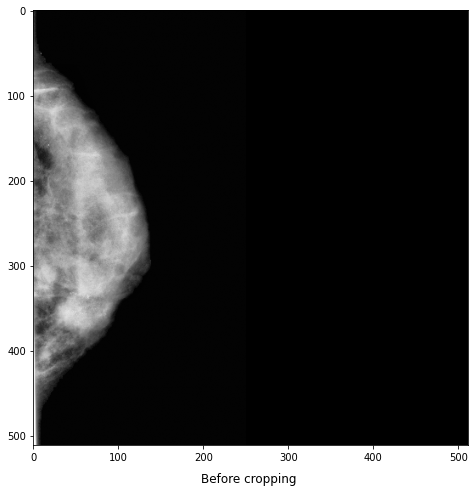

In [46]:
plt.figure(figsize = (50,8))
plt.imshow(res_x.numpy(), cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)

(512, 512, 3)


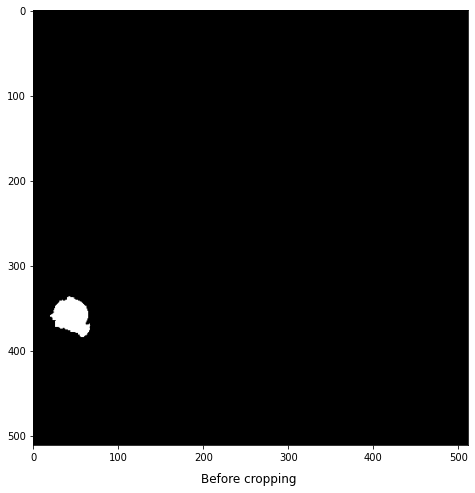

In [47]:
plt.figure(figsize = (50,8))
plt.imshow(res_y.numpy()[:,:,0], cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)
print(res_x.numpy().shape)

In [48]:
# res_y.numpy()[:,:,0].shape

In [49]:
# res_x.numpy().shape

In [50]:
prediction = unet.predict(test_ds)

In [51]:
# type(prediction)

In [52]:
# prediction.shape

In [53]:
# prediction[0].shape

(512, 512, 3)


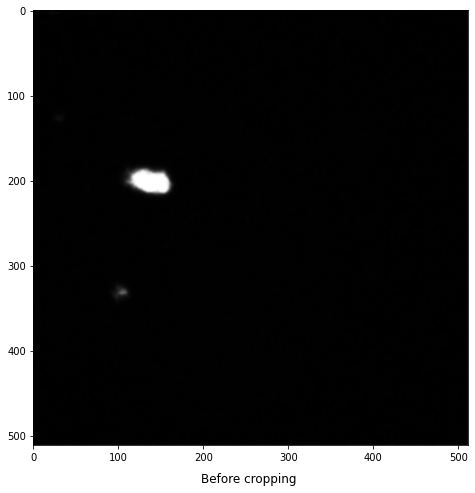

In [54]:
plt.figure(figsize = (50,8))
plt.imshow(prediction[i][:,:,0], cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)
print(res_x.numpy().shape)